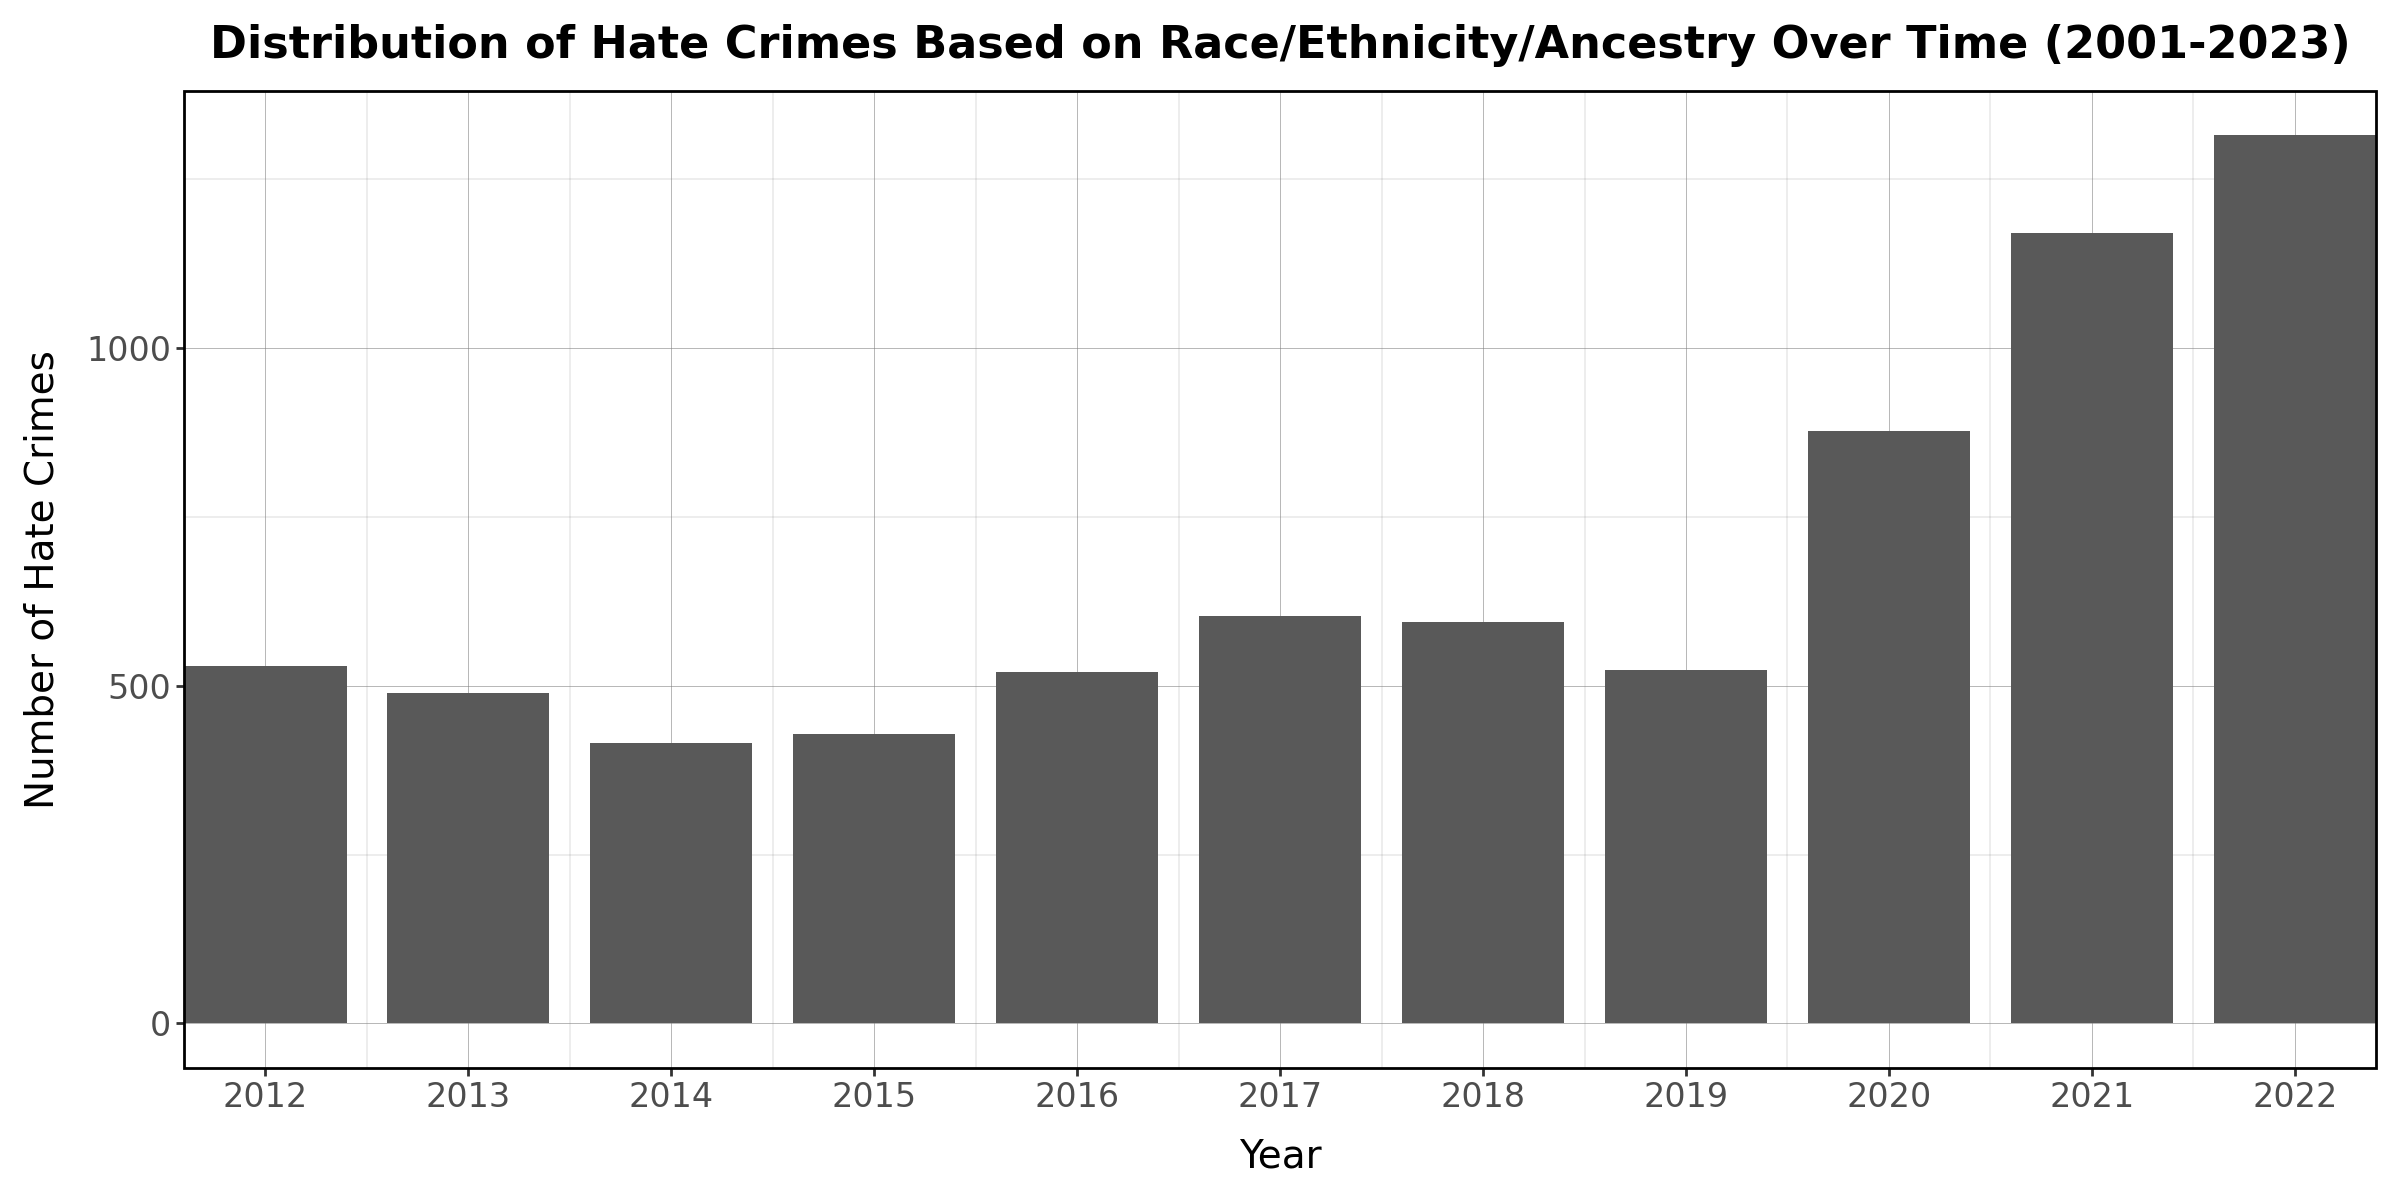

In [24]:
import pandas as pd
import plotnine as pn

file_path = r"C:\Users\Ilike\CSCI385\Final_Project\Hate Crime 2012 - 2022.csv"
data = pd.read_csv(file_path)

# Filter data for 'Race/Ethnicity/Ancestry'
race_ethnicity_ancestry_data = data[data['MostSeriousBiasType'] == 'Race/Ethnicity/Ancestry']

# Create a list of years from 2001 to 2023
years = list(range(2001, 2024))

# Create the plot
plot = (pn.ggplot(race_ethnicity_ancestry_data)
        + pn.aes(x='ClosedYear', fill='ClosedYear')  # Add color based on ClosedYear
        + pn.geom_bar(stat='count', width=0.8)  # Using geom_bar with stat='count' for alignment
        + pn.labs(
            title='Distribution of Hate Crimes Based on Race/Ethnicity/Ancestry Over Time (2001-2023)', 
            x='Year', 
            y='Number of Hate Crimes'
        )
        + pn.theme_bw()  # White background for clarity
        + pn.scale_x_continuous(
            breaks=years, 
            labels=[str(year) for year in years],
            expand=(0, 0)  # Remove padding from the x-axis
        )
        + pn.scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
        # A custom color palette for categorical data
        + pn.theme(
            figure_size=(12, 6),  # Adjust plot size for better title fit
            plot_title=pn.element_text(size=16, ha='center', weight='bold'),  # Make title bold and larger
            axis_title=pn.element_text(size=14),  # Axis titles size
            axis_text=pn.element_text(size=12),  # Axis labels size
            panel_grid_major=pn.element_line(color='gray', size=0.2),  # Lighter gridlines
            panel_grid_minor=pn.element_line(color='gray', size=0.1),  # Even lighter gridlines
            panel_border=pn.element_rect(color='black', size=1),  # Black border around the plot
            legend_position='none'  # Remove the legend as it's unnecessary for this plot
        )
)

# Display the plot
plot
